# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# global settings, fine for notebook
fcomb = np.arange(50e3,51.2e6,100e3)
Nb = len(fcomb)
kcomb = np.arange(1,2*Nb,2)
print (fcomb[0], fcomb[-1], Nb)
# true response
true_resp = np.exp(-(fcomb-30e6)**2/(2*25e6**2))
# our transmission code
code = np.exp(2*np.pi*1j*np.random.uniform(0,2*np.pi,Nb))
code_resp = code #* true_resp
dt = 4096/102.4e6  # time between frames 
phase_drift_per_ppm = fcomb*dt*(1/1e6)*2*np.pi
Nnotch = 16 #
alpha_to_pdrift = (Nnotch*phase_drift_per_ppm/kcomb)[0]


50000.0 51150000.0 512


In [49]:
def produce_data(alpha = -0.5, dalpha_dt = +0.0, sA=1, sc=None, ssig=None, Nintg = 64, add_noise = True):
    istart = 0
    last_phase = np.zeros(Nb)
    Nblock = Nnotch*Nintg
    while True:
        iend = istart+Nblock
        tar = np.arange(istart, iend)*dt
        alpha_ar = -(alpha+dalpha_dt*tar) #silly signs
        ampl_ar = sA*np.exp(-(tar-sc)**2/(2*ssig**2)) if sc is not None else sA*np.ones_like(tar)
        phase = last_phase + np.cumsum(np.outer(alpha_ar,phase_drift_per_ppm),axis=0)
        #print(alpha_ar,phase_drift_per_ppm)
        #print (phase[:,0])
        rot = np.exp(-1j*phase)
        data = code_resp[None,:]*ampl_ar[:,None]*rot
        t = tar.mean()
        calpha = alpha_ar.mean()
        dB = np.log10(ampl_ar.mean())*20 ## power is square of amplitude
        if add_noise:
            data += np.random.normal(0,1.0/np.sqrt(Nnotch), data.shape)
        ## integrate here
        data = data.reshape(Nintg,Nnotch,data.shape[1]).mean(axis=1)
        yield (t, calpha, dB, data)
        istart += Nblock
        last_phase = phase[-1,:]


In [50]:
def use_refspec_data(filename, Nintg=64, add_noise=False, SNR_dB=0):
    
    d=np.fromfile(open(filename,'rb'),dtype=np.csingle)
    d = d.reshape((-1,2048)) 
    # and now take just 50, 150, etc
    d = d[:,1::4]*1e7
    istart = 0
    if add_noise:
        rms_signal = np.sqrt((np.abs(d)**2).mean())
        rms_noise = rms_signal/Nnotch*10**(-SNR_dB/20)
        print (rms_noise)
    while True:
        iend = istart+Nintg
        if iend > d.shape[0]:
            break
        t = (istart+iend)/2*dt*Nnotch
        calpha = 0 
        data = d[istart:iend,:]
        if add_noise:
            
            data += np.random.normal(0,rms_noise, data.shape)
            
        yield (t,calpha, SNR_dB, data)
        istart = iend
        

In [117]:
def analyze_data (data_gen, tmax=30, countmax=None, Nintg = 64, alpha_start = 0, force_detect=False, maxdriftndx=None ):
    # Now we do the relatively 
    init_phase = np.ones(Nb, complex)
    detect = False
    pdrift = alpha_start*alpha_to_pdrift
    drift = []
    nullw = (-1)**np.arange(Nintg)
    Nblock = Nnotch*Nintg
    count = 0 
    for t, alpha, dB, data in data_gen:

        if t>tmax:
            break
        count += 1
        if countmax is not None:
            if count>countmax:
                break
        assert(data.shape[0]==Nintg)
        kar = np.outer(np.arange(Nintg+1),kcomb)
        
        if True:
        ## the actual statement
            phase_cor = np.exp(-1j*pdrift*kar)
        ## the "fast" statement
        else:
            tab = pdrift*kcomb
            phase_step = 1-(tab)**2/2 + 1j*tab
            phase_cor = np.array([phase_step**i for i in range(Nintg+1)])
        phase1 = init_phase*phase_cor
        init_phase = phase1[-1,:]
        data *= phase1[:-1,:]
        kar = kar[:-1,:]
        
        sum0 = data.sum(axis=0)
        sum0null = (data*nullw[:,None]).sum(axis=0)
        sum1 = (1j*kar*data).sum(axis=0)
        sum2 = (-kar**2*data).sum(axis=0)
        FD = np.real(sum1*np.conj(sum0))
        SD = np.real(sum2*np.conj(sum0)+sum1*np.conj(sum1))
        sig2 = np.abs(sum0**2)
        noise2 = np.abs(sum0null**2)
        SNRdB = np.log10(sig2.sum()/noise2.sum())*10
        print (sum0[2],sum1[2],sum2[2],'sums')
        print (FD[2], SD[2],'FDSD')
        yield t, alpha, dB, pdrift/alpha_to_pdrift, SNRdB, detect, sum0
        if maxdriftndx is not None:
            FD = FD[:maxdriftndx]
            SD = SD[:maxdriftndx]
        delta_drift = (FD.sum()/SD.sum())
        if force_detect:
            pdrift += delta_drift    
            print ('new pdrift = ', pdrift/alpha_to_pdrift)
        else:
            if np.abs(delta_drift)>0.05*alpha_to_pdrift:
                delta_drift = +0.05*alpha_to_pdrift
            pdrift = pdrift+delta_drift
            if np.abs(pdrift)>1.2*alpha_to_pdrift:
                pdrift = np.sign(pdrift)*1.2*alpha_to_pdrift*(-1)
       
        

    return 



In [76]:
data = use_refspec_data('../../refspec/calibrator_review22/notch_03.bin', Nintg=8, add_noise=False, SNR_dB=-10)
ana = analyze_data(data,tmax=30,Nintg=8, alpha_start=0.25, force_detect=True, maxdriftndx=500)

_,_,_,_,_,_, sum0=next(ana)
sum  = sum0
print (sum[2])
for i in range(2):
    _,_,_,_,_,_, sum0=next(ana)
    sum += sum0
    print (sum[2])



(1.0493556+13.305055j) (-232.83976078033447+18.345968052744865j) (-458.363613858819-5821.02028131485j) sums
-0.23760513908774783 -132480.908227749 FDSD
(1.0493556+13.305055j)
new pdrift =  0.2587547032440651
(1.0448283+13.305498j) (-232.84747421741486+18.268956691026688j) (-456.6757097840309-5821.194198727608j) sums
-0.20806068171445702 -132482.7372173252 FDSD
(2.094184+26.610554j)
new pdrift =  0.26647149318024255
(1.0404985+13.305864j) (-232.8540199995041+18.196624219417572j) (-454.6953096985817-5821.367892622948j) sums
-0.16244418563260865 -132483.5529665475 FDSD
(3.1346824+39.91642j)


In [88]:
Nintg=32
data = produce_data(alpha=-0.2, dalpha_dt=-0.00, Nintg=Nintg, add_noise=False)
v=list(analyze_data(data,tmax=2,Nintg=Nintg, alpha_start=+0.3))

(13.24301560888691+29.13074798157013j) (-2254.7955525751136+1032.5751921996787j) (-108732.22684512137-236611.1288766497j) sums
219.39499838916316 -14482916.253698181 FDSD
(13.732341129186965+28.90321981622298j) (-2236.763049374901+1071.0684498602216j) (-112802.48363381527-234697.65555881703j) sums
241.3336253545752 -14482856.67778264 FDSD
(14.263849117712825+28.64456046321675j) (-2216.2860642021205+1112.8130964108266j) (-117213.23855343382-232525.91295713655j) sums
263.27200293072605 -14482791.428210009 FDSD
(14.836107813591765+28.352294912108505j) (-2193.1704709558394+1157.6954800620397j) (-121952.42257746044-230075.40294535836j) sums
285.2101084473177 -14482720.505045637 FDSD
(15.447473770283366+28.023781345906503j) (-2167.2094022046804+1205.5852812110863j) (-127006.20339349203-227324.2989897112j) sums
307.1479192343957 -14482643.908360567 FDSD
(16.096071676167053+27.656226193876048j) (-2138.1844449416144+1256.3339355013625j) (-132358.81918437485-224249.5731741464j) sums
329.08541262

In [89]:
def reorder (x):
    a= []
    for i in range(7):
        a.append(np.array([l[i] for l in x]))
    return a

t1, inalpha1, inSNR1, alpha1, SNR1, detect1,_ = reorder(v)

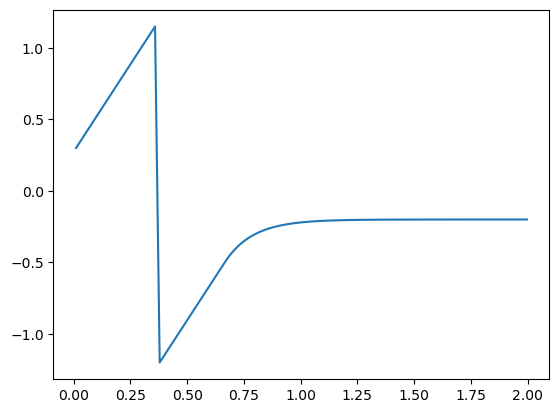

In [90]:
plt.plot(t1,alpha1)

In [102]:

res=[]
for Nintg in [128]:#, 128, 256]:
    data = produce_data(alpha=+0.3, dalpha_dt=-0.00, sc=15, ssig=3.5, Nintg=Nintg, add_noise=True)
    #data = use_refspec_data('../../refspec/calibrator_review22/03filtnotch.bin', Nintg=Nintg, add_noise=True, SNR_dB=-10)
    res.append ( list(analyze_data(data,tmax=30,Nintg=Nintg, alpha_start=-0.3, force_detect=False, maxdriftndx=500))) 


(-0.5861636045447558-0.0020647184226314686j) (3.5299208776482063-245.3893267207505j) (126864.52237675744+2364.137069733297j) sums
-1.5624512818025944 -134596.62901243614 FDSD
(1.1193782692917544+0.09459914423280201j) (-46.090419358949845+612.682886925273j) (-294228.0242498508-22126.60311464447j) sums
6.366662936260975 -708950.2609691252 FDSD
(-0.21364102791139172-0.0038575485578655096j) (1.4274473390181175-56.00200166747537j) (37743.96554001744+2305.806934505664j) sums
-0.08893087602726 -11210.816154305976 FDSD
(-0.028165843929963436+0.011485791258424586j) (2.8755484085623957-53.150966536016966j) (41091.111913574176+3703.6575823999747j) sums
-0.6914731545048245 -3948.120429545045 FDSD
(0.22036846793989634+0.05029265272516882j) (8.964591009573125-67.79255741377705j) (78997.31444718468+12907.490899711642j) sums
-1.43395436087476 13381.474380795622 FDSD
(-0.06881483887748008+0.00248641882945682j) (17.36765960311851-105.65084827178453j) (63034.25442175623+12109.976493798855j) sums
-1.45784

In [103]:



#sum1 = np.array([x[6] for x in res[0]])


# t, alpha, dB, pdrift/alpha_to_pdrift, SNRdB, detect, sum0

t1, inalpha1, inSNR1, alpha1, SNR1, detect1, _  = reorder(res[0])
#t2, inalpha2, inSNR2, alpha2, SNR2, detect2 =res[1].T
#t3, inalpha3, inSNR3, alpha3, SNR3, detect3 =res[2].T
#sum1.shape

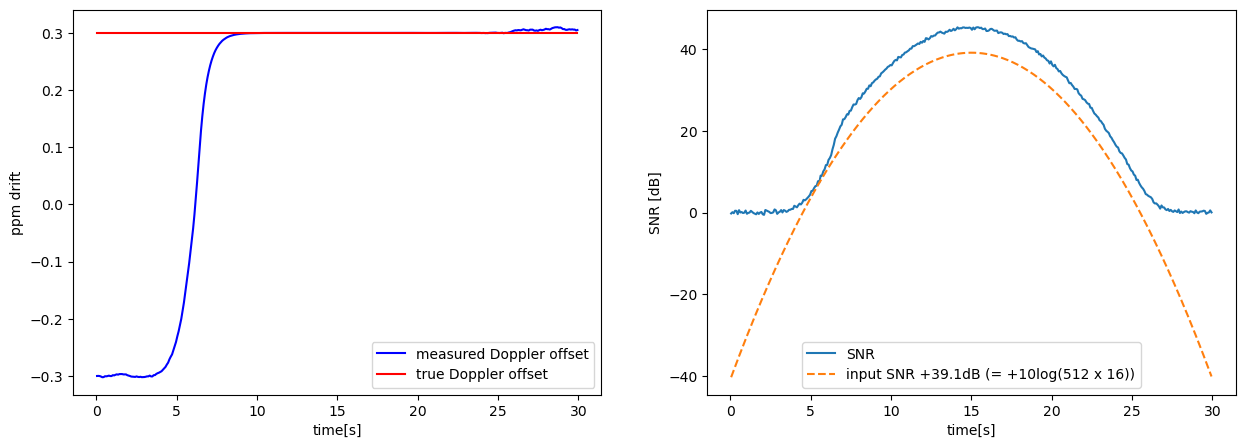

In [104]:

fig=plt.figure(figsize=(15,5))
ax1,ax2 = fig.subplots(nrows=1, ncols=2)
#inalpha1 = 0.3*np.ones_like(t1)
ax1.plot (t1,alpha1,'b-', label='measured Doppler offset')
ax1.plot (t1,-inalpha1,'r-', label='true Doppler offset')
ax1.set_xlabel('time[s]')
ax1.set_ylabel('ppm drift')
ax1.legend()

ax2.plot(t1,SNR1,label='SNR')
ax2.plot(t1,inSNR1+39.1,'--',label='input SNR +39.1dB (= +10log(512 x 16))')
ax2.set_xlabel('time[s]')
ax2.set_ylabel('SNR [dB]')
ax2.legend()

#plt.plot(t2,inalpha2,label='real Doppler offset')
#plt.plot (t2,-alpha2,'g-',label='measured Doppler offset')
#plt.plot(t2,detect2, label='detect flag')

#plt.plot(t3,inalpha3)
#plt.plot (t3,-alpha3,'b-')
#plt.plot(t3,detect3)

#plt.legend()
#plt.ylabel('ppm drift')

In [105]:
#Sum in bins of SNR
dSNR = 5
SNRbins = np.arange(1,45,dSNR)
sums = []
for s in SNRbins:
    w = np.where((SNR1>s) & (SNR1<s+dSNR))
    csum = sum1[w,:].sum(axis=1)[0]
    sums.append(csum)
    
#dt=7.5
#tbins = np.arange(0,30,dt)
#sums = []
#for s in tbins:
#    w = np.where((t1>s) & (t1<s+dt))
#    csum = sum1[w,:].sum(axis=1)[0]
#    sums.append(csum)

    
sums = np.array(sums)
#sumsc=sums

In [58]:


def phase_correct (avg):
    p = np.zeros(1025,complex)
    p[1::2] = avg*np.conj(code)
    guess = np.abs(np.fft.fft(p)).argmax()
    if guess>Nb//2:
        guess -= Nb
    rate_in = guess/(2*Nb)
    def fix (rate):
        return avg*np.exp(-1j*2*np.pi*rate*kcomb)
    def penalty (rate):
        pen = (np.imag(fix(rate)*np.conj(code))**2).sum()
        #print (rate,pen)
        return pen
    
    from scipy.optimize import minimize
    bounds = (rate_in-1/256,rate_in+1/256)
    #print (bounds)
    #res = minimize(penalty, rate_in,bounds = [bounds], method='powell')
    search = np.linspace(bounds[0],bounds[-1],10000)
    res = [penalty(x) for x in search]
    res = search[np.argmin(res)]
    print (rate_in, res)
    avgr = fix(res)
    return avgr


0.0869140625 0.08718244871362137
0.0869140625 0.08417199141789179
0.0869140625 0.09025072429117911
0.0869140625 0.08713009972872288
0.0869140625 0.08713244371312132
0.0869140625 0.08712384910366036
0.0869140625 0.08712463043179318
0.0869140625 0.08712463043179318


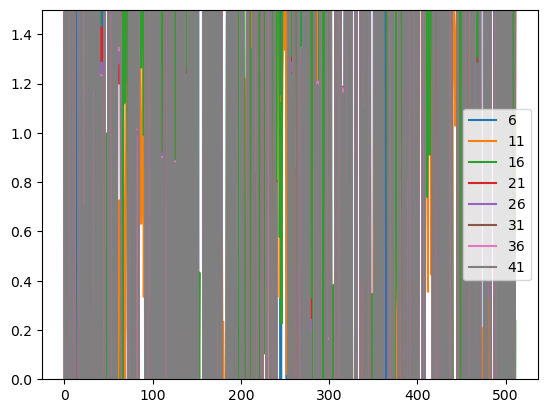

In [59]:


for i,v in enumerate(SNRbins[1:]):
    a = phase_correct(sums[i,:])

#def fix (rate):
#    return x*np.exp(-1j*2*np.pi*rate*kcomb)
#def penalty (rate):
#    pen = (np.imag(fix(rate)*np.conj(code))**2).sum()
    #    return pen
    u = np.real(a*np.conj(code))
    if np.real(u[0])<0:
        u = -u

    plt.plot(u/u[:10].mean(),label=str(v))


plt.ylim(0,1.5)

plt.legend()



In [60]:
plt.plot(np.real(sums[5,:]*np.conj(sums[12,:])))
len(sums)

IndexError: index 12 is out of bounds for axis 0 with size 9

In [114]:

res=[]
alpha_out = {32:[], 64:[], 128:[]}
alpha_in = np.linspace(-1.0,+1.0,100)
alpha_true = 0.0
for Nintg in [32, 64, 128]:
    for alpha_start in alpha_in:
        data = produce_data(alpha=alpha_true,  Nintg=Nintg, sA=0.1, add_noise=False)
        A = analyze_data(data,Nintg=Nintg, alpha_start=alpha_start, force_detect=True)
        next(A)
        alpha_out[Nintg].append(next(A)[3])
for Nintg in [32, 64, 128]:
    alpha_out[Nintg] = np.array(alpha_out[Nintg])   


(1.2555024767169949+2.9432688131589058j) (-228.64134174027876+96.0401905203302j) (-10021.065485580497-24034.025765956165j) sums
-4.3876732664893625 -21819.48968010962 FDSD
new pdrift =  -1.4537877064973947
(1.1390142479295633+2.9901140503864534j) (-232.44343340343846+86.41079303034043j) (-8979.816403091514-24441.577398126483j) sums
-6.378256139126263 -21814.467934147746 FDSD
(1.2564311024909913+2.9428785133708777j) (-228.6006141755864+96.13780357054391j) (-10032.600695824376-24029.23405398451j) sums
-4.2990452483260375 -21819.670066513507 FDSD
new pdrift =  -1.4423819476230755
(1.1414901754166464+2.9891746034745843j) (-232.36658908530748+86.61787391024458j) (-9002.322098931634-24433.31426299848j) sums
-6.328229636488526 -21814.616901663845 FDSD
(1.2573595627402867+2.942487817132123j) (-228.55983976148622+96.23539714551782j) (-10044.133459094119-24024.43643842388j) sums
-4.210416504934588 -21819.846772207187 FDSD
new pdrift =  -1.432905468218641
(1.1438752083653014+2.9882667508479197j) 

0.3737373737373738
0.17171717171717166
0.09090909090909094


Text(0, 0.5, 'output Doppler offset [ppm]')

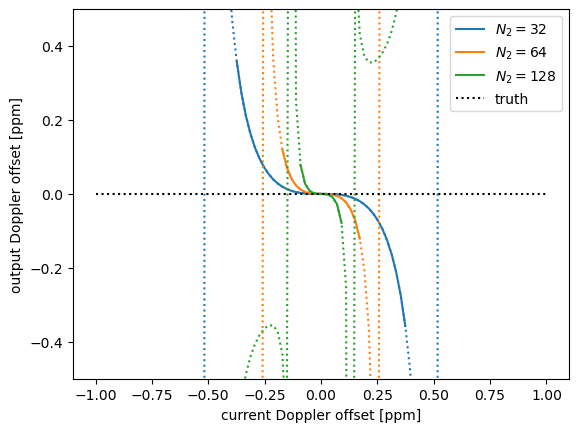

In [116]:
for Nintg in [32,64,128]:
    p=plt.plot(alpha_in, alpha_out[Nintg],':')
    
    w = np.where(np.abs(alpha_out[Nintg]-alpha_true)<np.abs(alpha_in-alpha_true))
    plt.plot(alpha_in[w], alpha_out[Nintg][w],color=p[0].get_color(),label=f'$N_2={Nintg}$')
    print ((alpha_in[w].max()-alpha_in[w].min())/2)

plt.plot(alpha_in, alpha_true*np.ones_like(alpha_in),'k:', label='truth')
plt.ylim(-0.5,0.5)
plt.legend()
plt.xlabel('current Doppler offset [ppm]')
plt.ylabel('output Doppler offset [ppm]')

In [ ]:
Nintg = 32
res=[]
alpha_var = {32:[], 64:[], 128:[]}
dblist = np.linspace(-60,0,50)
alpha_true = 0.0
for dbsnr in dblist:
    snr = 10**(dbsnr/20)
    for Nintg in alpha_var.keys():
        data = produce_data(alpha=0,  Nintg=Nintg, sA=snr, add_noise=True)
        res = []
        for i in range(10): 
            res0 = np.array(list(analyze_data(data,Nintg=Nintg, alpha_start=0, countmax = 12,  force_detect=True)))[5:,3]
            res = np.hstack((res,res0))
        alpha_var[Nintg].append(np.sqrt(res.var()))


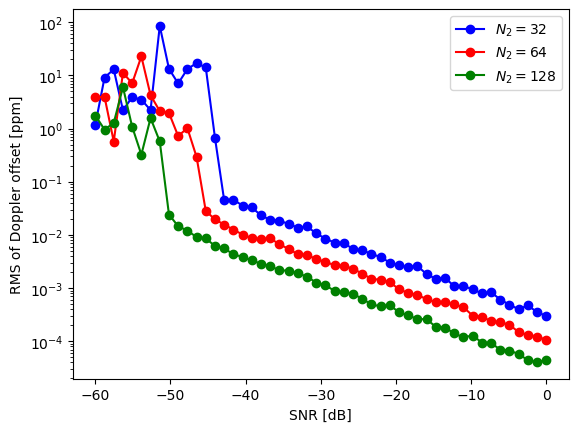

In [ ]:
plt.semilogy()
plt.plot(dblist, np.array(alpha_var[32]),'bo-', label='$N_2=32$')
plt.plot(dblist, alpha_var[64],'ro-', label='$N_2=64$')
plt.plot(dblist, alpha_var[128],'go-', label='$N_2=128$')
plt.xlabel('SNR [dB]')
plt.ylabel('RMS of Doppler offset [ppm]')
plt.legend()

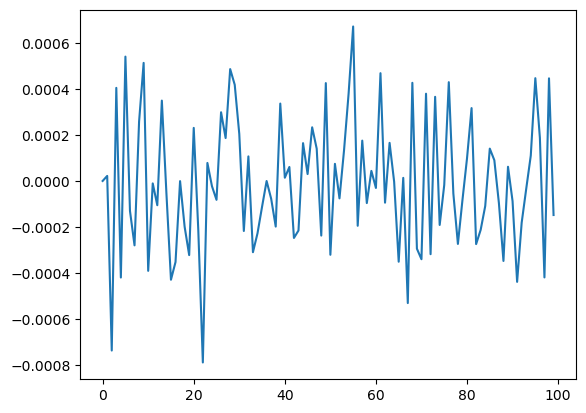

In [ ]:
plt.plot(res[:,3])

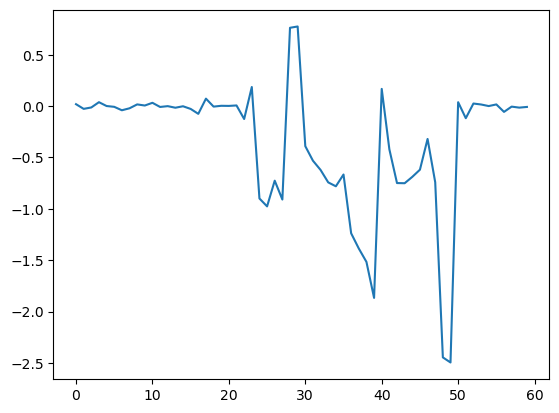

In [ ]:
plt.plot(res)

In [ ]:
data1 = next(use_refspec_data('../../refspec/calibrator_review22/03notch.bin', Nintg=1024))[3]
data2 = next(use_refspec_data('../../refspec/calibrator_review22/03filtnotch.bin', Nintg=1024+20))[3][20:,:]
data3 = data1-data2

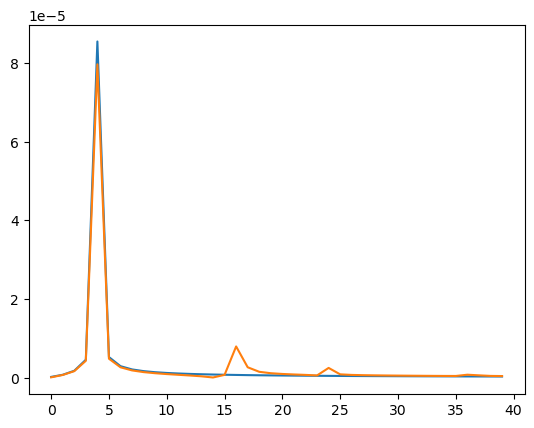

In [ ]:
plt.plot(np.abs(np.fft.rfft(data1[:,200])[:40]))
plt.plot(np.abs(np.fft.rfft(data2[:,200])[:40]))

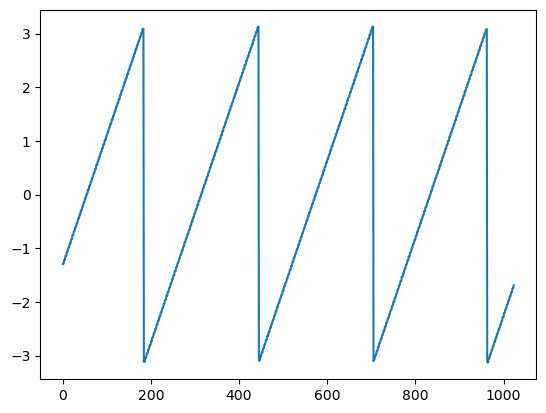

In [ ]:
rez=[]
alpha_rms=[]
dblist = np.linspace(-60,0,10)
for dbsnr in dblist:
    snr = 10**(dbsnr/20)
    Nintg=128
    data = produce_data(alpha=+0.3,  Nintg=Nintg, sA=snr, add_noise=True)
    res = list(analyze_data(data,Nintg=Nintg, alpha_start=0.3, countmax = 12,  force_detect=True))
    rez.append(np.array([r[-1] for r in res]))
    alpha_rms.append(np.sqrt(np.array([r[3] for r in res]).var()))




-0.1845703125 -0.18172666876062607
0.0 9.415004000400042e-05
0.0 1.5235898589859367e-05
0.0 -1.0547929792979228e-05
0.0 -7.422617261726092e-06
0.0 5.859960996099957e-06
0.0 7.422617261726092e-06
0.0 4.297304730472955e-06
0.0 5.078632863286456e-06
0.0 5.078632863286456e-06


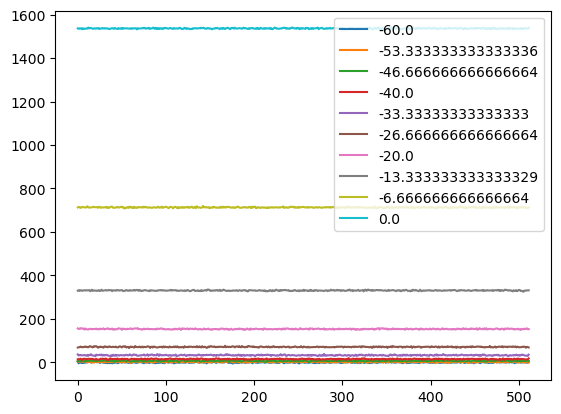

In [ ]:
for rx,v in list(zip(rez,dblist)):
    a = phase_correct(rx.sum(axis=0))
    u = np.real(a*np.conj(code))
    if np.real(u[0])<0:
        u = -u

    plt.plot(u,label=str(v))


#plt.ylim(0,1.5)

plt.legend()


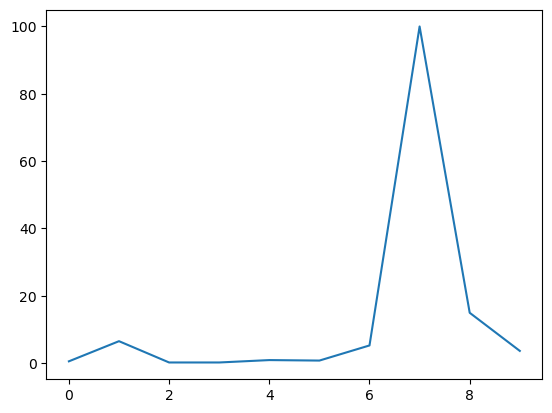

In [ ]:
plt.plot(alpha_rms)